In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms.v2 as transforms
from torchinfo import summary
from going_modular.module import data_loader, engine, utils
from scripts import helper_functions

In [2]:
import matplotlib.pyplot as plt

In [3]:
torch.__version__, torchvision.__version__

('2.1.0', '0.16.0')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

### Preparation:: Get Data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

image_path

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data/pizza_steak_sushi directory exists, skipping download.


In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
      Resize(size=[224, 224], interpolation=InterpolationMode.BILINEAR, antialias=warn)
      ToImage()
      ToDtype(scale=True)
)


In [7]:
train_dataloader, test_dataloader, classnames = data_loader.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=32, num_workers=4)

len(train_dataloader), len(test_dataloader), len(classnames)

(8, 3, 3)

### Visualize a single image

In [8]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

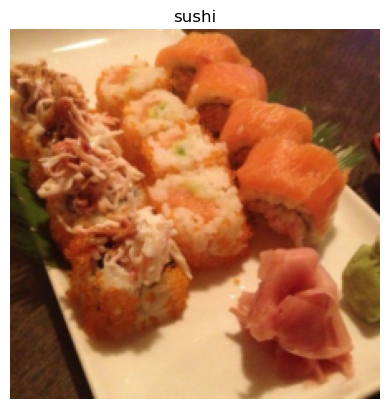

In [9]:
plt.imshow(image.permute(1,2,0))
plt.title(classnames[label])
plt.axis(False)

## Implementation

### Equation 1: Split data into patches and creating the class, position and patch embedding

4.1 Calculating patch embedding input and output shapes by hand¶

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Image shape {image.shape}")
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Image shape torch.Size([3, 224, 224])
Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196
Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


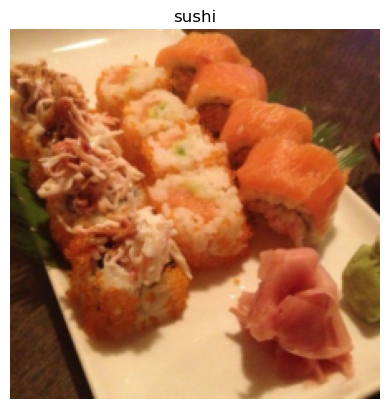

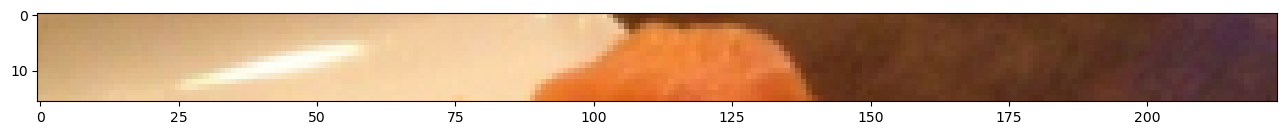

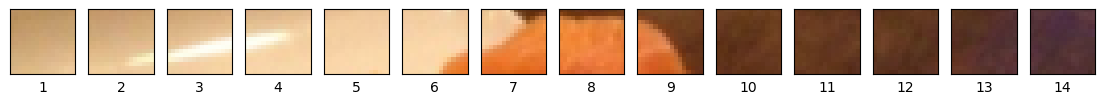

In [11]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(classnames[label])
plt.axis(False);


# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);


# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


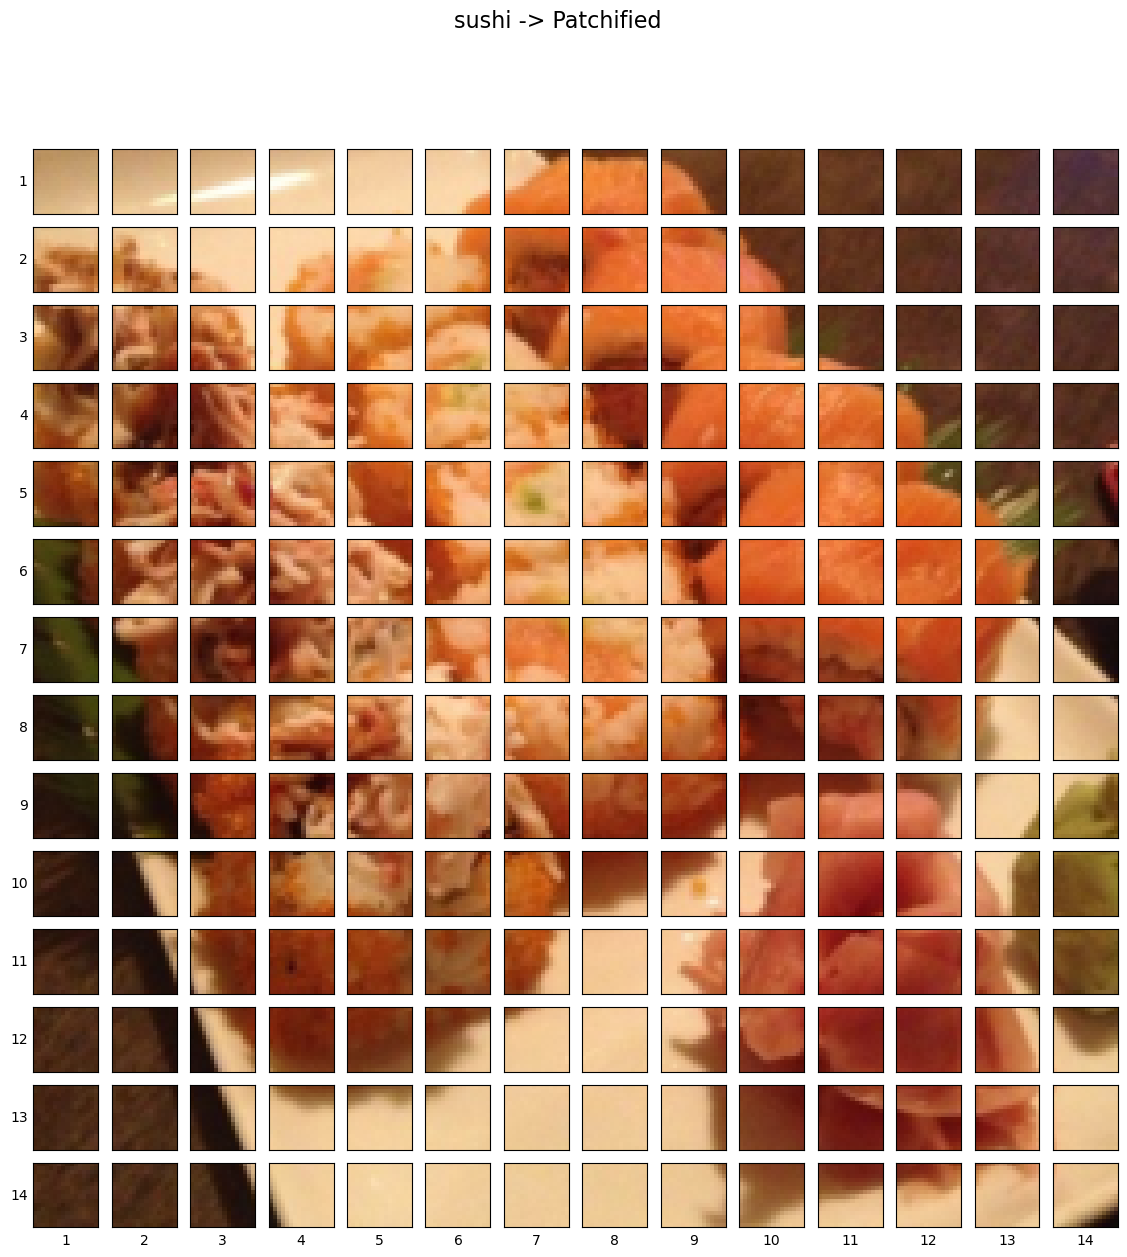

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right",                   verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{classnames[label]} -> Patchified", fontsize=16)
plt.show()

#### 4.3 Creating image patches with torch.nn.Conv2d()
 

In [13]:
patch_size = 16

# 768 -> D (Hidden Size D)
conv2d = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size, padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [14]:
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape, image_out_of_conv.requires_grad # learnable feature embeddings ... total 14*14 = 196 patches ... each patch has embedding of dim 768

(torch.Size([1, 768, 14, 14]), True)

In [15]:
flatten_layer = nn.Flatten(start_dim=2,end_dim=3)
image_out_of_flatten = flatten_layer(image_out_of_conv)
image_out_of_flatten.shape
# image_out_of_conv.reshape(1,768,196).shape

torch.Size([1, 768, 196])

In [16]:
flattened_image = image_out_of_flatten.permute(0,2,1)
flattened_image.shape

torch.Size([1, 196, 768])

In [17]:
# plt.imshow(image.permute(1,2,0))
# plt.title(classnames[label])
# plt.axis(False)

In [18]:
# EXTRA:: Plot random 5 convolutional feature maps/activation maps / Note: These are not feature vectors
# import random  
# random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
# print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# for i, idx in enumerate(random_indexes):
#     image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
#     axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
#     axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

#### 4.5 Turning the ViT patch embedding layer into a PyTorch module


In [19]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector"""
    def __init__(self, embed_dim = 768, patch_size = 16): # embed_dim = D
        super().__init__()
        self.conv2d_layer = nn.Conv2d(in_channels=3, out_channels=embed_dim,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten_layer = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self, x):

        # Ideally you should assert this separately ... and not part of forward
        img_resol = x.shape[-1]
        assert img_resol % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {img_resol}, patch size: {patch_size}"

        x = self.conv2d_layer(x)
        x = self.flatten_layer(x)
        x = x.permute(0,2,1)
        return x

In [20]:
patchify = PatchEmbedding()
image.unsqueeze(dim=0).shape , patchify(image.unsqueeze(dim=0)).shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 196, 768]))

In [21]:
embedded_image = patchify(image.unsqueeze(dim=0))
B, N, D = embedded_image.shape   # B -> batch_size, N -> Sequence Length (# of Image Patches), D -> Embedding Dim

In [22]:
cls_embedding = nn.Parameter(torch.ones(1,1,D)).expand(B,-1,-1) # ideally should be torch.randn
# class_token.shape
patch_embedded_image_with_class_embedding = torch.cat([cls_embedding,embedded_image],dim=1)

In [23]:
print(f"Sequence of patch embeddings with class token prepended shape:\n {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Sequence of patch embeddings with class token prepended shape:
 torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [24]:
print(f"Sequence of patch embeddings with class token prepended shape: \n{patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Sequence of patch embeddings with class token prepended shape: 
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


#### 4.7 Creating the position embedding


In [25]:
# Get embedding dimension
B, N, D = embedded_image.shape

# Create the learnable 1D position embedding
# torch.randn instead of torch.ones
position_embedding = nn.Parameter(torch.ones(1, N+1, D), requires_grad=True) # make learnable

print(f"Position embeddding shape:\n{position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position embeddding shape:
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [26]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
# print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: \n{patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Patch embeddings, class token prepended and positional embeddings added shape: 
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


#### 4.8 Creating embedding representation -> Putting it all together

In [27]:
set_seeds(42)

patch_size = 16
C, H, W = image.shape
embed_dim = 768

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(patch_size=patch_size, embed_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
cls_embedding = nn.Parameter(torch.ones(batch_size, 1, embed_dim), requires_grad=True)
print(f"Class token embedding shape: {cls_embedding.shape}")

# 7. Prepend class token embedding to patch embedding
class_and_path_embedding = torch.cat((cls_embedding, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {class_and_path_embedding.shape}")

# 8. Create position embedding
N = int((height * width) / patch_size**2) # N = number of patches
position_embedding = nn.Parameter(torch.ones(1, N+1, embed_dim), requires_grad=True) # make learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = class_and_path_embedding + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### 4.9 Creating a Class out of it

In [28]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector"""
    def __init__(self, embed_dim = 768, patch_size = 16, image_dim = (224,224)): # embed_dim = D
        super().__init__()
        N = (image_dim[0] * image_dim[1]) // patch_size**2 
        self.conv2d_layer = nn.Conv2d(in_channels=3, out_channels=embed_dim,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten_layer = nn.Flatten(start_dim=2,end_dim=3)
        self.cls_token_embedding = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(1, N+1, embed_dim), requires_grad=True)

    def forward(self, x):

        batch_size = x.shape[0]

        x = self.conv2d_layer(x)
        x = self.flatten_layer(x)
        patch_embedding = x.permute(0,2,1)
        cls_embedding = self.cls_token_embedding.expand(batch_size, -1, -1)
        
        cls_and_patch_embedding = torch.cat((cls_embedding, patch_embedding), dim=1)
        patch_and_position_embedding = cls_and_patch_embedding + self.position_embedding
        return patch_and_position_embedding

In [29]:
patchify = PatchEmbedding()
print(patchify(image.unsqueeze(0)).shape)

patched_image = patchify(image.unsqueeze(0))

torch.Size([1, 197, 768])


### Equation 2: Multi-Head Attention (MSA)

In [30]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """MultiHeadSelfAttentionBlock"""
    def __init__(self, embed_dim = 768, num_heads = 12, dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        # batch_first = True -> (batch, sequence, features) == (batch, num_patches, embedd_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim,num_heads=num_heads, batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.multihead_attn(query=x, key=x, value=x, need_weights = False)
        return x

In [31]:
MSA = MultiHeadSelfAttentionBlock()
output, _ = MSA(patched_image)
output.shape


torch.Size([1, 197, 768])

### 6. Equation 3: Multilayer Perceptron (MLP)

In [32]:
class MLPBlock(nn.Module):
    """MLP"""
    def __init__(self, embed_dim = 768, mlp_size = 3072, dropout = 0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)

        self.mlp = nn.Sequential(
                                nn.Linear(in_features=embed_dim, out_features=mlp_size),
                                nn.GELU(),
                                nn.Dropout(p=dropout),
                                nn.Linear(in_features=mlp_size, out_features=embed_dim),
                                nn.Dropout(p=dropout))
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [33]:
MLP = MLPBlock()

output = MLP(output)
output.shape

torch.Size([1, 197, 768])

In [34]:
class TransformerEncoderBlock(nn.Module):
    """TransformerEncoder"""
    def __init__(self, embed_dim = 768, num_heads = 12, mlp_size = 3072, dropout=0.1):
        super().__init__()
        self.msa_block = MultiHeadSelfAttentionBlock(embed_dim=embed_dim, num_heads=num_heads, dropout=0)
        self.mlp_block = MLPBlock(embed_dim=embed_dim, mlp_size=mlp_size, dropout = dropout)

    def forward(self, x):
        x = self.msa_block(x)[0] + x  # multihead_block returns the attention weights as well
        x = self.mlp_block(x) + x
        return x

In [35]:
manual_encoder =  TransformerEncoderBlock()
manual_encoder_output = manual_encoder(output)

In [36]:
manual_encoder_output.shape

torch.Size([1, 197, 768])

In [37]:
summary(model=manual_encoder,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create TransformerEncoder block with Pytorch Inbuilt Transformer

In [38]:
auto_encoder = nn.TransformerEncoderLayer(d_model=768, # Hidden size D / embed_dim
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size
                                                             dropout=0.1, # Amount of dropout for dense layers 
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) 

In [39]:
auto_encoder_output = auto_encoder(output)
auto_encoder_output.shape

torch.Size([1, 197, 768])

In [40]:
summary(model=auto_encoder,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [41]:
class ViTBase(nn.Module):
    """ViTBase"""
    def __init__(self,
                 img_size = 224,
                 in_channels = 3,
                 patch_size = 16,
                 num_transformer_layers = 12,
                 embed_dim = 768,
                 mlp_size = 3072,
                 num_heads = 12,
                 attn_dropout = 0,
                 mlp_dropout= 0.1,
                 embed_dropout = 0.1,
                 num_clases = 1000   # we want it to be 3 in our case
                 ):
        super().__init__()

        assert img_size % patch_size == 0, f"img_size, patch_size incompatible"

        self.patch_embedding = PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size, image_dim=(img_size, img_size))

        self.embedding_dropout = nn.Dropout(p = embed_dropout)

        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(embed_dim=embed_dim, num_heads=num_heads,mlp_size=mlp_size, dropout=mlp_dropout) for _ in range(num_transformer_layers)]
        )

        self.classifier = nn.Sequential(
                nn.LayerNorm(normalized_shape=embed_dim),
                nn.Linear(in_features=embed_dim, out_features=num_clases)
        )


    def forward(self, x):

        x = self.patch_embedding(x)
        # print(f"{x.shape}")
        x = self.transformer_encoder(x)
        # print(f"{x.shape}")
        x = self.classifier(x[:,0,:])
        # print(f"{x.shape}")
        return x

In [46]:
vit = ViTBase(num_clases=len(classnames))
output = vit(image.unsqueeze(0))

output.shape

torch.Size([1, 3])

In [43]:
summary(vit, image.unsqueeze(0).shape,
        col_names=["input_size", "output_size", "num_params", "trainable"],)

/home/heyia/miniforge3/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
ViTBase                                            [1, 3, 224, 224]          [1, 3]                    --                        True
├─PatchEmbedding: 1-1                              [1, 3, 224, 224]          [1, 197, 768]             152,064                   True
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          590,592                   True
│    └─Flatten: 2-2                                [1, 768, 14, 14]          [1, 768, 196]             --                        --
├─Sequential: 1-2                                  [1, 197, 768]             [1, 197, 768]             --                        True
│    └─TransformerEncoderBlock: 2-3                [1, 197, 768]             [1, 197, 768]             --                        True
│    │    └─MultiHeadSelfAttentionBlock: 3-1       [1, 197,

### Training code

In [50]:
device = torch.device('cpu')

In [51]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device
                       )

  0%|          | 0/5 [00:00<?, ?it/s]

: 